# Import package

In [62]:
import os
import math
import time 
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from collections import Counter

# Global variable

In [63]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.device('/gpu:0')
print(device_lib.list_local_devices())
label_classes = ['森森', '牛排', '巧巧', '小白', '花捲', '黑胖', '乖狗', '橘子', '烏龜', '松鼠', '笨鳥']

num_of_class = len(label_classes)
batch_size = 32
target_size = (224, 224)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7726664812844508408
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6286213120
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7545296418874149485
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


# Preprocess data

In [64]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=15,
    # shear_range=0.1,
    zoom_range=0.1,
    # fill_mode='nearest'
)

# train
train_generator = train_datagen.flow_from_directory(
    directory="data/",
    target_size=target_size,
    color_mode="rgb",
    class_mode='categorical',
    classes=label_classes,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

for i, j in Counter(train_generator.classes).items():
    print(f"{label_classes[i]} with {j:3d} images")
print()

# valid
valid_generator = train_datagen.flow_from_directory(
    directory="data/",
    target_size=target_size,
    color_mode="rgb",
    class_mode='categorical',
    classes=label_classes,
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)
for i, j in Counter(valid_generator.classes).items():
    print(f"{label_classes[i]} with {j:3d} images")
    

Found 1319 images belonging to 11 classes.
森森 with 162 images
牛排 with 173 images
巧巧 with 176 images
小白 with 157 images
花捲 with 109 images
黑胖 with 133 images
乖狗 with 166 images
橘子 with 111 images
烏龜 with  66 images
松鼠 with  22 images
笨鳥 with  44 images

Found 141 images belonging to 11 classes.
森森 with  17 images
牛排 with  19 images
巧巧 with  19 images
小白 with  17 images
花捲 with  12 images
黑胖 with  14 images
乖狗 with  18 images
橘子 with  12 images
烏龜 with   7 images
松鼠 with   2 images
笨鳥 with   4 images


烏龜


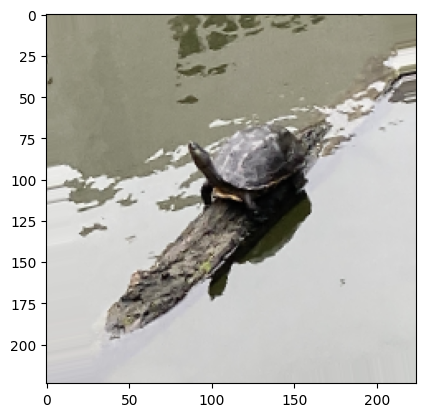

牛排


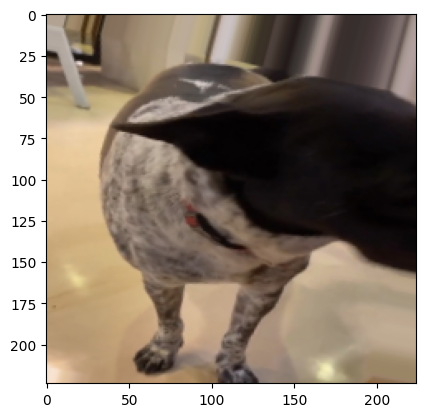

牛排


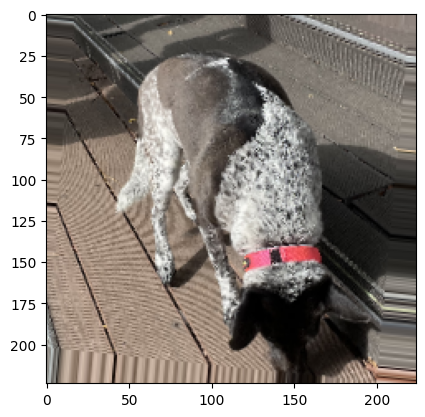

In [65]:
for my_batch in train_generator:
    images = my_batch[0]
    labels = my_batch[1]
    for i in range(3):
        print(label_classes[labels[i].argmax()])
        plt.imshow(images[i])
        plt.show()
    break

# Build model

In [70]:
base_model = tf.keras.applications.MobileNetV2(
    include_top = False,
    input_shape = target_size + (3, ),
    weights = 'imagenet'
)

base_model.trainable = False

# base_model.summary()

# # fine tune
# for layer in base_model.layers:
#     if(layer.name in ['Conv_1', 'Conv_2']):
#         layer.trainable = True
#     else:
#         layer.trainable = False

model = models.Sequential([
    base_model,
    # layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    # layers.Dense(units=64, activation='relu'),
    layers.Dense(num_of_class, activation='softmax')
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_14  (None, 1280)              0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 11)                14091     
Total params: 2,272,075
Trainable params: 14,091
Non-trainable params: 2,257,984
_________________________________________________________________


# Start training

In [71]:
# Set model

my_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_save/weights_L_{epoch:03d}_{val_accuracy:.2f}.hdf5',
    # filepath='weights_save/weights_S_{epoch:03d}_{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    save_weights_only=True,
    mode='max'
)]

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

Epoch 1/10
41/41 [==============================] - 38s 838ms/step - loss: 1.9032 - accuracy: 0.4126 - val_loss: 0.5669 - val_accuracy: 0.8750
Epoch 2/10
41/41 [==============================] - 31s 769ms/step - loss: 0.6855 - accuracy: 0.7762 - val_loss: 0.3111 - val_accuracy: 0.8984
Epoch 3/10
41/41 [==============================] - 33s 806ms/step - loss: 0.4495 - accuracy: 0.8500 - val_loss: 0.2946 - val_accuracy: 0.9219
Epoch 4/10
41/41 [==============================] - 33s 798ms/step - loss: 0.3450 - accuracy: 0.8897 - val_loss: 0.2190 - val_accuracy: 0.9375
Epoch 5/10
41/41 [==============================] - 32s 774ms/step - loss: 0.3069 - accuracy: 0.9075 - val_loss: 0.1991 - val_accuracy: 0.9375
Epoch 6/10
41/41 [==============================] - 32s 784ms/step - loss: 0.2694 - accuracy: 0.9052 - val_loss: 0.2022 - val_accuracy: 0.9297
Epoch 7/10
41/41 [==============================] - 32s 776ms/step - loss: 0.2173 - accuracy: 0.9332 - val_loss: 0.1670 - val_accuracy: 0.9531

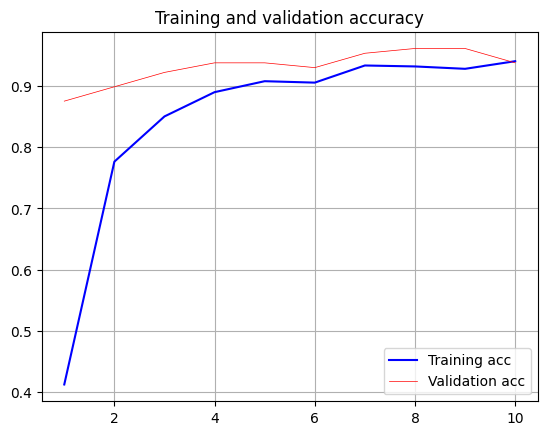

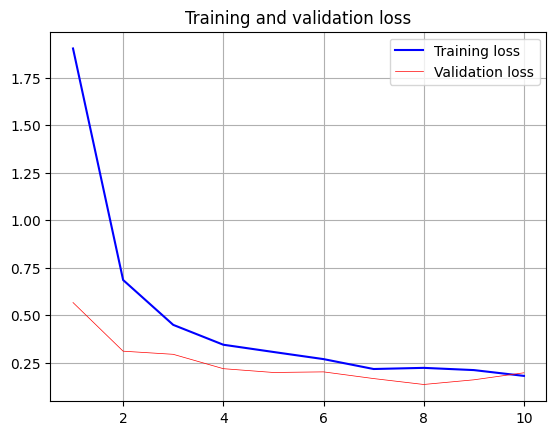

In [72]:
# model.load_weights(filepath='weights_save/weights_L_005_0.72.hdf5')
# model.load_weights(filepath='weights_save/weights_S_005_0.72.hdf5')

history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=10,
    # callbacks=my_callback
)

acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc', linewidth=0.5)
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.grid()
# 儲存acc學習曲線
# plt.savefig('./acc.png')
plt.show()
# 畫出loss學習曲線
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=0.5)
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid()
# 儲存loss學習曲線
# plt.savefig('loss.png')
plt.show()

In [73]:
pred_train = model.evaluate(train_generator, verbose=0, steps=STEP_SIZE_TRAIN)
pred_val = model.evaluate(valid_generator, verbose=0, steps=STEP_SIZE_VALID)

print("Train loss:", pred_train[0])
print("Train accuracy:", pred_train[1])
print("Validation loss:", pred_val[0])
print("Validation accuracy:", pred_val[1])

Train loss: 0.08507218956947327
Train accuracy: 0.9817073345184326
Validation loss: 0.16960853338241577
Validation accuracy: 0.9453125


In [74]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    directory='test/',
    target_size=target_size,
    color_mode="rgb",
    class_mode='categorical',
    classes=label_classes,
)

images = []
labels = []
predictions = []

for data, label in test_generator:
    
    prediction = np.argmax(model.predict(data), axis=1)
    predictions.extend(prediction)
    
    images.extend(data)
    
    labels.extend(np.argmax(label, axis=1))
    
    if (len(predictions) == test_generator.n):
        break

Found 7 images belonging to 11 classes.


In [ ]:
images = []
labels = []
predictions = []

for data, label in valid_generator:
    
    prediction = np.argmax(model.predict(data), axis=1)
    predictions.extend(prediction)
    
    images.extend(data)
    
    labels.extend(np.argmax(label, axis=1))
    
    if (len(predictions) == valid_generator.n):
        break

label=小白 | predict=小白


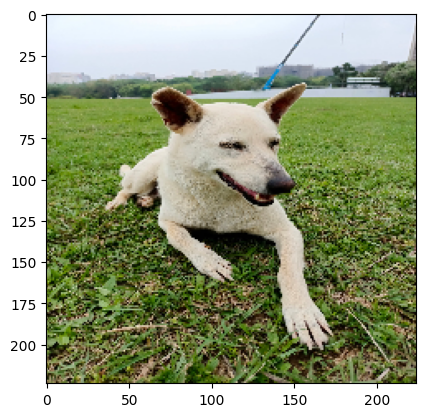

label=牛排 | predict=牛排


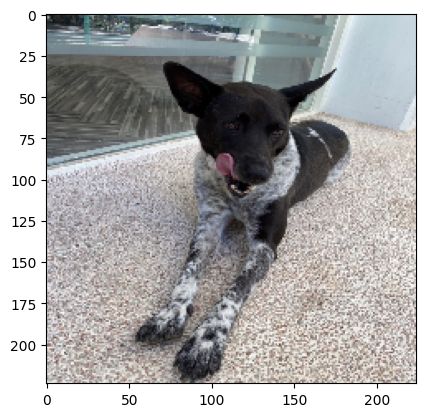

label=乖狗 | predict=乖狗


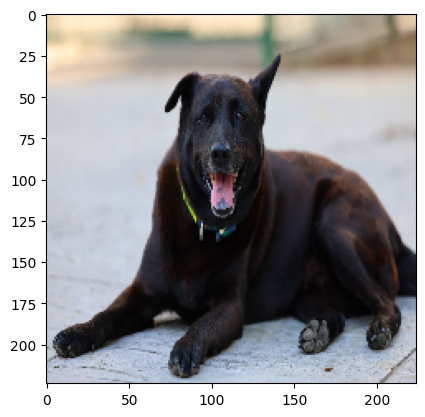

label=橘子 | predict=橘子


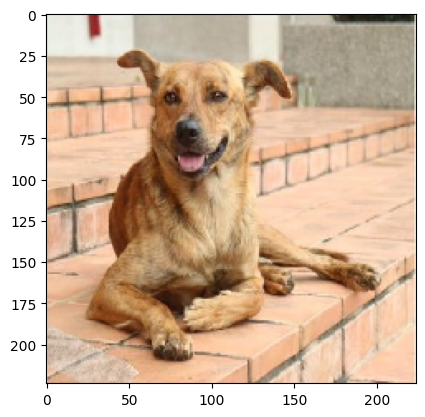

label=巧巧 | predict=巧巧


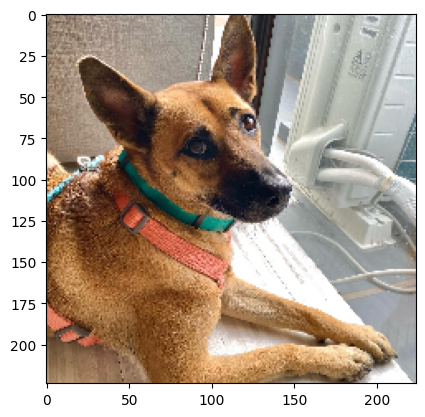

label=森森 | predict=森森


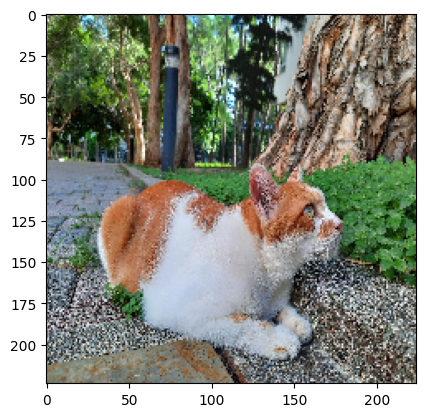

label=黑胖 | predict=乖狗


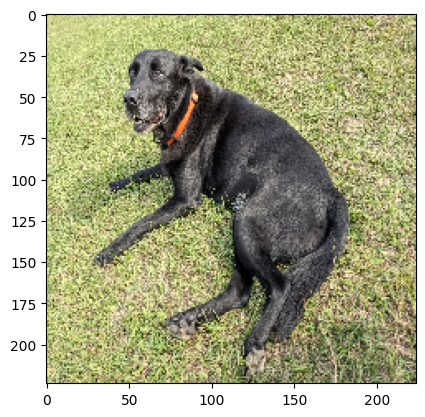

In [76]:
for i in range(test_generator.n):
    print(f"label={label_classes[labels[i]]} | predict={label_classes[predictions[i]]}")
    # plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.show()

# Convert to tflite

In [77]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as fh:
    fh.write(tflite_model)

c:\Users\user\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpi58y9wfo\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpi58y9wfo\assets
